In [1]:
# #############################################################################
# Methods for retriveing and manipulating the DataRobot prediction explanations
#  for a new dataset
# #############################################################################
from functools import reduce
import datarobot as dr
import pandas as pd

/Users/chandler.mccann/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
#Download and Show Wine Table
nba = pd.read_csv('DR_Demo_NBA_2017-2018.csv', encoding='latin-1')
nba[0:15]

,roto_fpts_per_min,roto_minutes,roto_fpts,roto_value,free_throws_lag30_mean,field_goals_decay1_mean,game_score_lag30_mean,minutes_played_decay1_mean,PF_lastseason,free_throws_attempted_lag30_mean,...,team,opponent,over_under,eff_field_goal_percent_lastseason,spread_decay1_mean,position,OWS_lastseason,free_throws_percent_decay1,text_yesterday_and_today,game_score
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.1,NaN,...,PHO,POR,NaN,0.475,NaN,SG,1.3,NaN,NaN,8.1
1,NaN,NaN,NaN,NaN,0.000000,6.000000,8.100000,27.066667,3.1,0.000000,...,PHO,LAL,NaN,0.475,-48.000000,SG,1.3,NaN,NaN,18.6
2,NaN,NaN,NaN,NaN,1.500000,8.000000,13.350000,35.511111,3.1,2.500000,...,PHO,LAC,NaN,0.475,-17.333333,SG,1.3,0.600000,NaN,5.4
3,NaN,NaN,NaN,NaN,2.000000,6.285714,10.700000,33.380952,3.1,3.000000,...,PHO,SAC,NaN,0.475,-31.428571,SG,1.3,0.692308,NaN,16.5
4,NaN,NaN,NaN,NaN,2.500000,7.200000,12.150000,30.955556,3.1,3.250000,...,PHO,UTA,NaN,0.475,-13.600000,SG,1.3,0.862069,NaN,8.4
5,NaN,NaN,NaN,NaN,2.200000,7.096774,11.400000,31.976344,3.1,2.800000,...,PHO,POR,NaN,0.475,-1.935484,SG,1.3,0.891892,NaN,25.5
6,NaN,NaN,NaN,NaN,3.166667,9.079365,13.750000,33.173545,3.1,3.833333,...,PHO,BRK,NaN,0.475,-4.507937,SG,1.3,0.889503,NaN,20.7
7,NaN,NaN,NaN,NaN,3.428571,10.047244,14.742857,34.329134,3.1,4.000000,...,PHO,WAS,NaN,0.475,1.795276,SG,1.3,0.941349,NaN,18.3
8,NaN,NaN,NaN,NaN,3.625000,8.517647,15.187500,34.038431,3.1,4.125000,...,PHO,NYK,NaN,0.475,3.905882,SG,1.3,0.969743,NaN,23.0
9,NaN,NaN,NaN,NaN,4.555556,9.260274,16.055556,33.693542,3.1,5.000000,...,PHO,SAS,NaN,0.475,-4.563601,SG,1.3,0.990897,Suns' Devin Booker: Drops 34 points on Knicks ...,0.4


In [1]:
# ######################################################################
# UTILITY FUNCTIONS FOR CLEAN RE_USABLE BEHAVIOUR - thanks to John Hawkins for this piece
# ######################################################################
def unlist(listOfLists):
    return [item for sublist in listOfLists for item in sublist]

def unique_elements(bigList):
    return reduce(lambda l, x: l.append(x) or l if x not in l else l, bigList, [])


# #####################################################################
# Generic method to do everything required to retrieve the scores and
# explanations for a given data set.
# #####################################################################
def retrieve_prediction_explanations(proj, mod, pdata, n_reasons = 5):
    # UPLOAD THE DATASET
    dataset = proj.upload_dataset(pdata) # Returns an instance of [PredictionDataset]
    pred_job = mod.request_predictions(dataset.id)
    preds = pred_job.get_result_when_complete()
    # NOW WE NEED TO ENSURE THAT FEATURE IMPACT EXISTS FOR THAT MODEL
    try:
        impact_job = mod.request_feature_impact()
        impact_job.wait_for_completion(300)
    except dr.errors.JobAlreadyRequested:
        pass  # already computed
    # NOW ENSURE THAT THE PREDICTION EXPLANATIONS ARE COMPUTED 
    try:
        dr.PredictionExplanationsInitialization.get(proj.id, mod.id)
    except dr.errors.ClientError as e:
        assert e.status_code == 404  # haven't been computed
        init_job = dr.PredictionExplanationsInitialization.create(proj.id, mod.id)
        init_job.wait_for_completion()
    # RUN THE REASON CODE JOB
    rc_job = dr.PredictionExplanations.create(proj.id,
                               mod.id,
                               dataset.id,
                               max_explanations=n_reasons,
                               threshold_low=None,
                               threshold_high=None)
    rc = rc_job.get_result_when_complete(max_wait=1200)
    all_rows = rc.get_all_as_dataframe()
    return all_rows


# #############################################################
# TRANSFORMATION OF THE PREDICTION EXPLANATIONS INTO A SET OF 
# COLUMNS PER FEATURE WITH THE QUANTITATIVE PREDICTION STRENGTH 
# VALUE IN THE DATA CELL
# WE NEED TO KNOW THE PROJECT TYPE TO DETERMINE THE COLUMN NUMBER
# WHERE THE EXPLANATIONS START.
# #############################################################
def get_strength_per_feature_cols(proj, all_rows, n_reasons=5):
    colsToUse = []
    startPoint = 6
    if proj.target_type == 'Regression':
        startPoint = 2
    if proj.target_type == 'Binary':
        startPoint = 6
    j = startPoint
    for i in range(n_reasons):
        colsToUse.append(j) 
        colsToUse.append(j+4)
        j = j + 5 
    rc3 = all_rows.iloc[:, colsToUse]
    j = 0
    colsForNames = []
    for i in range(n_reasons):
        colsForNames.append(j) 
        j = j + 2 
    namesdf = rc3.iloc[:,colsForNames]
    allfeatures = [namesdf[i].unique().tolist() for i in namesdf.columns]
    nameslist = unique_elements(unlist(allfeatures))
    ####################################################################
    # CREATE A NEW DATAFRAME WITH ONE COLUMN PER POSSIBLE REASON CODE
    # INITIALISE TO ZERO AND THEN FILL WITH THE EXPLANATION STRENGTHS
    ####################################################################
    dfnew = pd.DataFrame(columns=nameslist)
    for j in range(len(rc3)):
        dfnew.loc[j] = [0 for n in range(len(nameslist))]
        for i in range(n_reasons):
            rcname = rc3.loc[j][i*2] 
            rcvalue = rc3.loc[j][i*2+1]
            dfnew.loc[j][rcname] = rcvalue    
    return dfnew    

In [6]:
# LOAD THE PROJECT AND MODEL FOR THE NBA DATA
PROJECT_ID = '5c87de2779bffe67cf2e176e'
MODEL_ID = '5c87dfa1295bb1647d87fa71'
proj = dr.Project.get(project_id=PROJECT_ID)
mod =  dr.Model.get(PROJECT_ID, model_id=MODEL_ID)


In [125]:
dr.__version__

'2.14.2'

In [7]:
output = retrieve_prediction_explanations(proj,mod,nba, n_reasons=10)

In [9]:
output

,row_id,prediction,explanation_0_feature,explanation_0_feature_value,explanation_0_label,explanation_0_qualitative_strength,explanation_0_strength,explanation_1_feature,explanation_1_feature_value,explanation_1_label,...,explanation_8_feature,explanation_8_feature_value,explanation_8_label,explanation_8_qualitative_strength,explanation_8_strength,explanation_9_feature,explanation_9_feature_value,explanation_9_label,explanation_9_qualitative_strength,explanation_9_strength
0,0,10.669949,threes_percent_lag30,,game_score,+++,2.156920,free_throws_percent_decay1,,game_score,...,turnovers_decay1_std,,game_score,++,0.712176,roto_fpts,,game_score,++,0.696571
1,1,11.700363,player_id,bookede01,game_score,+++,1.645316,roto_fpts,,game_score,...,free_throws_percent_decay1,,game_score,-,-0.285789,text_yesterday_and_today,,game_score,+,0.261115
2,2,13.497095,roto_fpts_per_min,,game_score,++,0.966812,roto_fpts,,game_score,...,minutes_played_decay1_mean,35.5111,game_score,+,0.285761,turnovers_decay1_mean,4,game_score,+,0.271405
3,3,14.233800,player_id,bookede01,game_score,++,1.315382,roto_fpts,,game_score,...,field_goal_attempts_lag30_mean,16.6667,game_score,++,0.570090,text_yesterday_and_today,,game_score,++,0.521496
4,4,12.960188,roto_fpts,,game_score,++,0.903159,roto_fpts_per_min,,game_score,...,points_decay1_mean,19.3333,game_score,-,-0.235872,defensive_rating_decay1_mean,118.933,game_score,-,-0.209256
5,5,13.356206,roto_fpts_per_min,,game_score,++,1.004747,roto_fpts,,game_score,...,threes_percent_lag30,0.307692,game_score,+,0.285666,minutes_played_decay1_mean,31.9763,game_score,+,0.254025
6,6,14.815258,roto_fpts_per_min,,game_score,++,1.193666,roto_fpts,,game_score,...,over_under,,game_score,++,0.525452,points_decay1_mean,26.1905,game_score,++,0.419092
7,7,14.853486,roto_fpts,,game_score,++,1.139621,roto_fpts_per_min,,game_score,...,turnovers_decay1_mean,3.81102,game_score,++,0.594293,game_score_decay1_mean,19.4811,game_score,++,0.538194
8,8,13.942984,roto_fpts_per_min,,game_score,++,1.031770,roto_fpts,,game_score,...,location,away,game_score,+,0.305358,game_score_decay1_mean,18.8882,game_score,+,0.302810
9,9,10.365176,player_id,bookede01,game_score,--,-1.143041,text_yesterday_and_today,Suns' Devin Booker: Drops 34 points on Knicks ...,game_score,...,game_score_lag30_mean,16.0556,game_score,--,-0.535588,moneyline,,game_score,--,-0.416672


In [10]:
flattened = get_strength_per_feature_cols(proj,output,n_reasons=10)

In [11]:
flattened.head()

,threes_percent_lag30,player_id,roto_fpts_per_min,roto_fpts,text_yesterday_and_today,rest,team,over_under,moneyline,opponent,...,spread_decay1_mean,free_throws_attempted_lastseason,PPG_lastseason,total_rebound_percent_decay1_std,free_throws_lastseason,OWS_lastseason,PF_lastseason,field_goals_lastseason,TS_Percent_lastseason,usage_percent_lastseason
0,2.15692,0.892296,0,0.696571,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1.64532,0.707125,0.770707,0.261115,0.632796,0.427543,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.609626,0.966812,0.914735,0.305584,0.796193,0.550595,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1.31538,0.957602,0.988266,0.521496,0.816645,0.666083,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.287407,0.882137,0.903159,0.346902,0.756604,0.506621,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# take the flattened prediction explanation strenghts per row, and reduce their dimensionality and cluster

In [14]:
import umap
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(10,8)})

In [15]:
#Recommended settings for UMAP, but can use other dimensionality reduction techniques.  N_neighbors influences the density 
#requirement per cluster
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(flattened)

In [16]:
print(flattened.shape)
print(clusterable_embedding.shape)

(9999, 50)
(9999, 2)


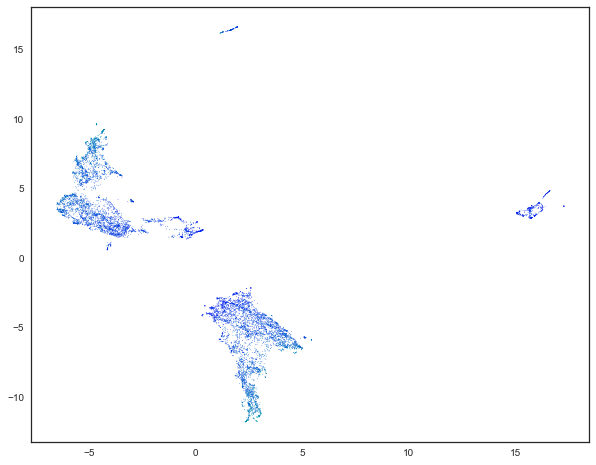

In [18]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=nba.game_score, 
            s=0.1, cmap='winter');

# run clustering, get clusterd IDs, and append to original data and flattened prediction explanation data

In [19]:
###Get cluster labels for your dataset
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

In [20]:
##See how many clusters 
set(labels)

#NB - -1 is a cluster of "noise" for HDBSCAN and should not be viewed as an actual cluster

{-1, 0, 1, 2, 3}

In [21]:
# clusterer = hdbscan.HDBSCAN(min_cluster_size=15, prediction_data=False).fit(clusterable_embedding)
# pal = sns.color_palette('deep', 15)
# colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_,
#                                                             clusterer.probabilities_)]
# plt.scatter(clusterable_embedding[:,0], clusterable_embedding[:,1], c=colors, **plot_kwds);

In [23]:
#clusterer.probabilities_

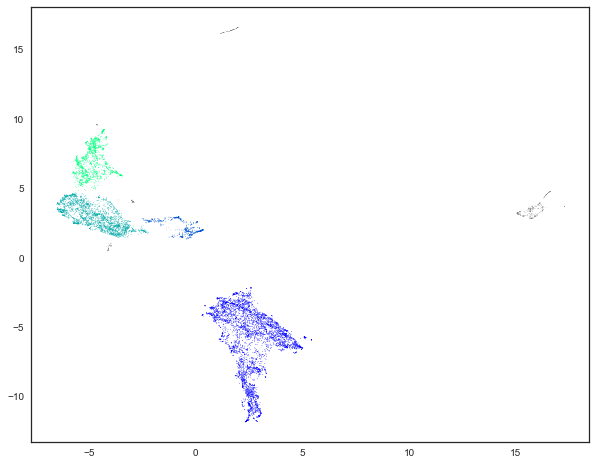

In [24]:
clustered = (labels >= 0)  ###  the -1 cluster is noise within HDBSCAN
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='winter');

# We found a major cluster, two medium sized ones and a smaller one. Let's map these back to the actual values and see what we can find

In [25]:
#our clusters is an array of dimension 1, the length of our data set
labels.shape

(9999,)

In [31]:
#add the clusters to our prediction explanation data set (flattened) and our origninal data set
flattened['clusters']=labels
flattened['predicted_score'] = output['prediction']
nba['clusters']=labels

In [34]:
flattened.clusters.value_counts()

 0.0    4844
 2.0    2412
 3.0    1459
-1.0     748
 1.0     536
Name: clusters, dtype: int64

In [32]:
flattened = flattened.astype(np.float64)

In [33]:
expl_df = pd.DataFrame(flattened.groupby('clusters').mean().T)
expl_df.columns=['Noise', 'cluster_A', 'cluster_B', 'cluster_C', 'cluster_D']
expl_df

#we can see that cluster D is associated with a high game score, cluster B a low one, and so on

,Noise,cluster_A,cluster_B,cluster_C,cluster_D
threes_percent_lag30,0.338196,0.009228,-0.114579,0.008042,-0.002567
player_id,0.134585,0.196531,-0.638508,-0.406103,1.886644
roto_fpts_per_min,-0.541696,0.027213,0.111444,0.561637,0.966886
roto_fpts,-0.453373,0.047692,0.121729,0.552076,1.032706
text_yesterday_and_today,-0.273449,0.049870,-1.135451,0.267560,0.405613
rest,0.006023,0.020677,0.182069,0.618015,0.934980
team,-0.015218,0.060671,-0.375193,0.033189,0.459275
over_under,-1.716520,0.175991,-1.274684,0.009353,-0.076610
moneyline,-0.838475,0.112359,-0.571507,0.021541,-0.077478
opponent,-0.001614,0.001619,0.000487,0.018921,-0.000293


In [35]:
#append clusters to the original prediction data

In [36]:
nba['clusters']=labels
nba['predicted_game_Score']= output['prediction']

In [37]:
actual_df = pd.DataFrame(nba.groupby('clusters').mean().T)
actual_df

clusters,-1,0,1,2,3
roto_fpts_per_min,0.000000,0.992232,1.065714,0.970877,1.135455
roto_minutes,0.000000,29.867271,29.857143,28.315789,33.121212
roto_fpts,0.000000,29.990028,31.985714,27.694737,37.684848
roto_value,0.000000,4.671676,4.737143,4.828421,4.931212
free_throws_lag30_mean,2.045035,2.362578,1.564559,2.034996,3.438417
field_goals_decay1_mean,2.759912,5.410633,2.316246,4.840348,6.870510
game_score_lag30_mean,9.151665,11.053861,7.163898,9.504143,14.597280
minutes_played_decay1_mean,14.775565,28.446144,12.069084,27.885948,32.045377
PF_lastseason,2.274930,2.112903,2.123108,2.051827,2.311815
free_throws_attempted_lag30_mean,2.660411,3.009749,2.005059,2.598936,4.311682


In [3]:
# now we can see that the actual values for cluster D are much higher than the other clusters, row wiswe

In [40]:
final_df = actual_df
final_df['-1_actual']=expl_df['Noise']
final_df['0_actual']=expl_df['cluster_A']
final_df['1_actual']=expl_df['cluster_B']
final_df['2_actual']=expl_df['cluster_C']
final_df['3_actual']=expl_df['cluster_D']
#final_df.drop('-1_atual', axis=1, inplace=True)

In [41]:
final_df.columns=['Noise_actual_mean','clust_A_actual_mean','clust_B_actual_mean','clust_C_actual_mean',
                  'clust_D_actual_mean',
                  'Noise_expl_mean','clust_A_expl_mean','clust_B_expl_mean','clust_C_expl_mean','clust_D_expl_mean' ]

In [42]:
final_df

,Noise_actual_mean,clust_A_actual_mean,clust_B_actual_mean,clust_C_actual_mean,clust_D_actual_mean,Noise_expl_mean,clust_A_expl_mean,clust_B_expl_mean,clust_C_expl_mean,clust_D_expl_mean
roto_fpts_per_min,0.000000,0.992232,1.065714,0.970877,1.135455,-0.541696,0.027213,0.111444,0.561637,0.966886
roto_minutes,0.000000,29.867271,29.857143,28.315789,33.121212,-0.585196,0.084157,0.125887,0.552359,0.905394
roto_fpts,0.000000,29.990028,31.985714,27.694737,37.684848,-0.453373,0.047692,0.121729,0.552076,1.032706
roto_value,0.000000,4.671676,4.737143,4.828421,4.931212,-0.698486,0.046497,0.098863,0.524401,0.666861
free_throws_lag30_mean,2.045035,2.362578,1.564559,2.034996,3.438417,-0.000627,0.018390,-0.004131,0.002892,0.071303
field_goals_decay1_mean,2.759912,5.410633,2.316246,4.840348,6.870510,-0.032286,-0.034089,-0.051468,0.000218,0.002854
game_score_lag30_mean,9.151665,11.053861,7.163898,9.504143,14.597280,-0.010679,-0.088134,-0.052863,-0.084460,0.042213
minutes_played_decay1_mean,14.775565,28.446144,12.069084,27.885948,32.045377,-0.124765,-0.038512,-1.124033,0.120607,0.075876
PF_lastseason,2.274930,2.112903,2.123108,2.051827,2.311815,0.000000,-0.000089,0.000000,0.000032,0.000000
free_throws_attempted_lag30_mean,2.660411,3.009749,2.005059,2.598936,4.311682,-0.001436,0.019094,-0.008388,-0.009281,0.050351


In [43]:
final_df.to_csv('nba_expl_clusters.csv')

In [ ]:
# could be interesting to run a 1 vs all project here for each cluster and look for important features